In [1]:
import sys
sys.path.append("../../")

from models.message import Message
from models.run import Run
from models.duck_basemodel import DuckDBModel
DuckDBModel.initialize_db('/home/hessel/code/master-thesis/databases/fraud-prod.db')  # Use ':memory:' for in-memory database

In [38]:
[(x.id, x.metadata['application']['llm']['model_name']) 
 for x in Run.list_all() 
 if len(x.get_messages()) > 500]

[(12, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (16, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (30, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (36, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (38, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (41, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (50, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (56, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (85, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (99, 'Phi-3.5-mini-instruct-Q4_K_S'),
 (101, 'llama-3.2-3b-instruct-q8_0'),
 (109, 'llama-3.2-3b-instruct-q8_0'),
 (126, 'Phi-3.5-mini-instruct-Q8_0'),
 (130, 'Hermes-3-Llama-3.1-8B.Q4_K_M'),
 (131, 'gemma-2-9b-it-Q4_K_M'),
 (133, 'Mistral-Nemo-Instruct-2407-Q4_K_M'),
 (134, 'gemma-2-9b-it-Q4_K_M'),
 (137, 'smollm2-1.7b-instruct-q4_k_m'),
 (139, 'Qwen2.5-7B-Instruct.Q4_K_M'),
 (141, 'Meta-Llama-3.1-8B-Instruct-Q4_K_M')]

In [32]:
run = Run.get(id=116)
# Create visualization
run.model_name
run.get_message_stats_df

<bound method Run.get_message_stats_df of Run(id=116, start_time=datetime.datetime(2024, 11, 21, 22, 42, 29, 907978), end_time=datetime.datetime(2024, 11, 21, 22, 42, 39, 760476), model_name='llama-3.2-3b-instruct-q8_0.gguf', environment='production', status='completed', metadata={'system': {'cpu': {'physical_cores': 12, 'total_cores': 20, 'cpu_freq': {'current': 4278.828350000001, 'min': 800.0, 'max': 4700.0}, 'cpu_percent': [4.0, 96.0, 40.0, 41.6, 71.0, 5.0, 64.6, 9.9, 16.0, 78.2, 84.0, 2.0, 4.9, 71.7, 55.6, 23.2, 34.3, 15.0, 14.0, 15.2]}, 'memory': {'total': 33491701760, 'available': 26115375104, 'percent_used': 22.0}, 'gpu': {'cuda_available': True, 'gpu_count': 1, 'devices': [{'name': 'NVIDIA GeForce RTX 3070', 'memory_total': 8318681088, 'memory_allocated': 0, 'memory_cached': 0}]}, 'platform': {'system': 'Linux', 'release': '6.8.0-49-generic', 'version': '#49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2', 'machine': 'x86_64'}}, 'application': {'broker': {'url': [

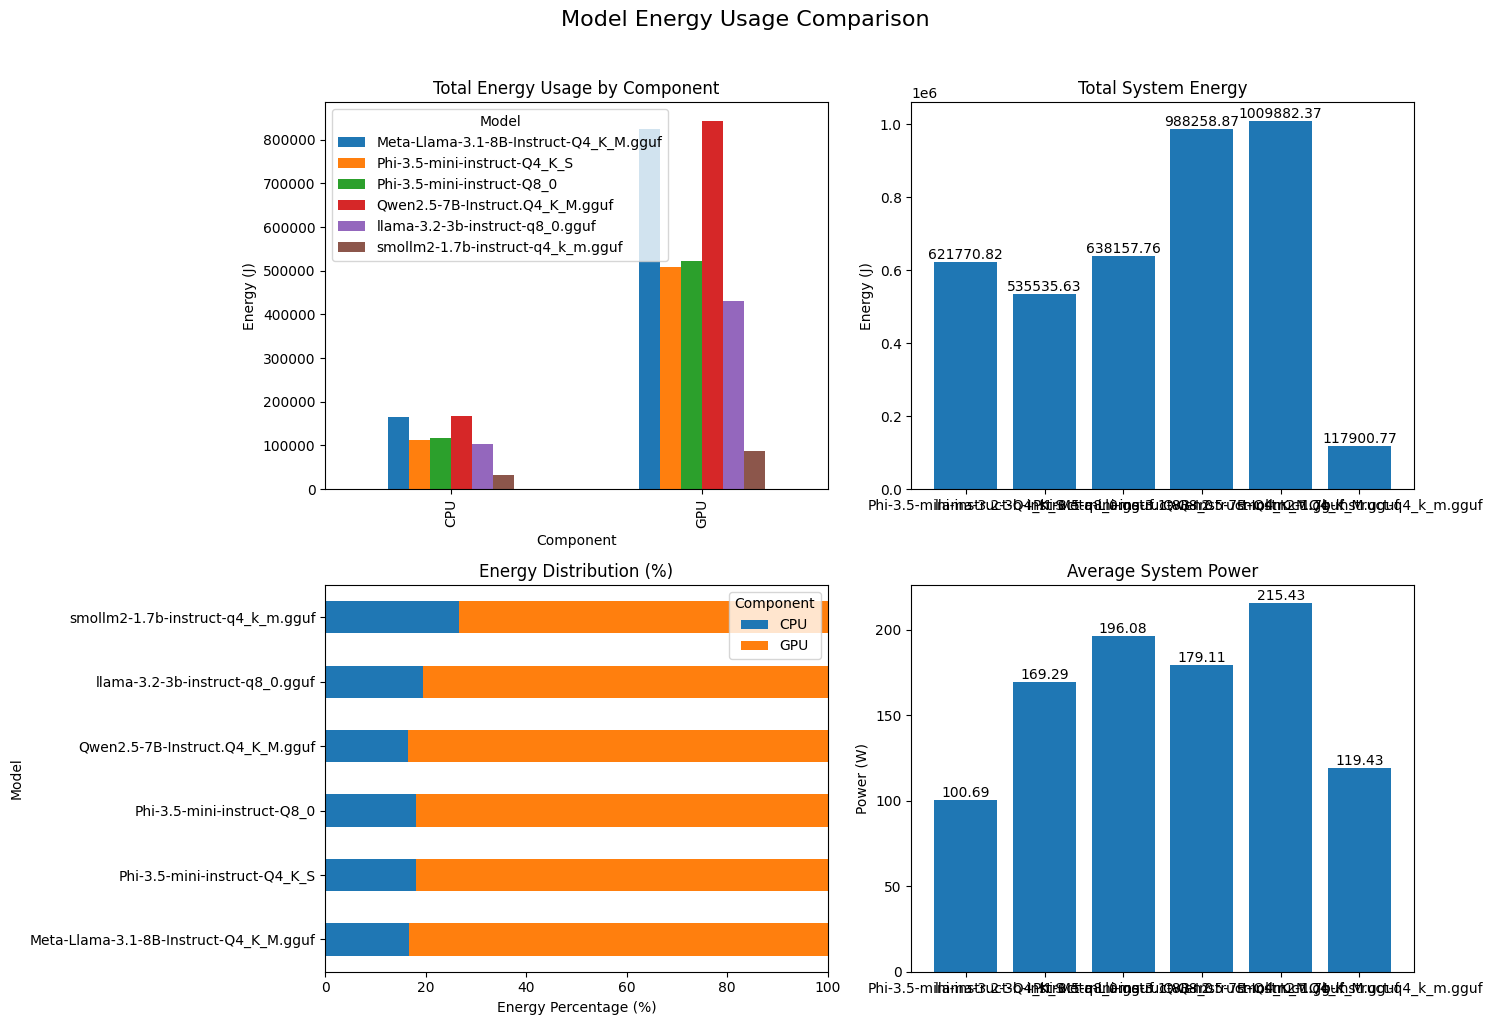

In [ ]:
# Required imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime

# List of run IDs to compare
run_ids = [99, 109, 126, 141, 130, 134, 139, 137]  # Add your run IDs here

# Collect stats for each run
model_stats = {}
for run_id in run_ids:
    run = Run.get(id=run_id)
    model_stats[run.model_name] = run.get_power_stats_df()

def plot_model_comparisons(model_stats_dict, figsize=(15, 10)):
    """
    Create comparative visualizations of power statistics across different models.
    
    Args:
        model_stats_dict: Dictionary with model names as keys and their stats DataFrames as values
        figsize: Tuple specifying the figure size
    """
    # Create figure with subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    fig.suptitle('Model Energy Usage Comparison', size=16, y=1.02)
    
    # Color palette
    colors = sns.color_palette("husl", len(model_stats_dict))
    
    # 1. Total Energy by Component
    component_data = []
    for model, df in model_stats_dict.items():
        for _, row in df[df['Component'] != 'System Total'].iterrows():
            component_data.append({
                'Model': model,
                'Component': row['Component'],
                'Total Energy (J)': row['Total Energy (J)']
            })
    comp_df = pd.DataFrame(component_data)
    comp_pivot = comp_df.pivot(index='Component', columns='Model', values='Total Energy (J)')
    comp_pivot.plot(kind='bar', ax=ax1)
    ax1.set_title('Total Energy Usage by Component')
    ax1.set_ylabel('Energy (J)')
    ax1.legend(title='Model')
    
    # 2. System Total Comparison
    system_totals = []
    for model, df in model_stats_dict.items():
        total_row = df[df['Component'] == 'System Total'].iloc[0]
        system_totals.append({
            'Model': model,
            'Total Energy (J)': total_row['Total Energy (J)'],
            'Average Power (W)': total_row['Average Power (W)']
        })
    totals_df = pd.DataFrame(system_totals)
    
    ax2.bar(totals_df['Model'], totals_df['Total Energy (J)'])
    ax2.set_title('Total System Energy')
    ax2.set_ylabel('Energy (J)')
    
    # 3. Energy Distribution
    distribution_data = []
    for model, df in model_stats_dict.items():
        component_data = df[df['Component'] != 'System Total']
        for _, row in component_data.iterrows():
            distribution_data.append({
                'Model': model,
                'Component': row['Component'],
                'Percentage': row['Energy Percentage (%)']
            })
    
    dist_df = pd.DataFrame(distribution_data)
    
    # Plot stacked horizontal bars
    pivot_df = dist_df.pivot(index='Model', columns='Component', values='Percentage')
    pivot_df.plot(kind='barh', stacked=True, ax=ax3)
    
    ax3.set_title('Energy Distribution (%)')
    ax3.set_xlabel('Energy Percentage (%)')
    ax3.legend(title='Component')
    ax3.set_xlim(0, 100)  # Ensure x-axis goes from 0 to 100%
    
    # 4. Average Power Comparison
    ax4.bar(totals_df['Model'], totals_df['Average Power (W)'])
    ax4.set_title('Average System Power')
    ax4.set_ylabel('Power (W)')
    
    # Add value labels on bars for plots 2 and 4
    for ax in [ax2, ax4]:
        for container in ax.containers:
            ax.bar_label(container, fmt='%.2f')
    
    plt.tight_layout()
    return fig

# Create the comparison plots
fig = plot_model_comparisons(model_stats)
plt.show()

# You can also save the figure if needed
# fig.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

<Figure size 1500x800 with 0 Axes>

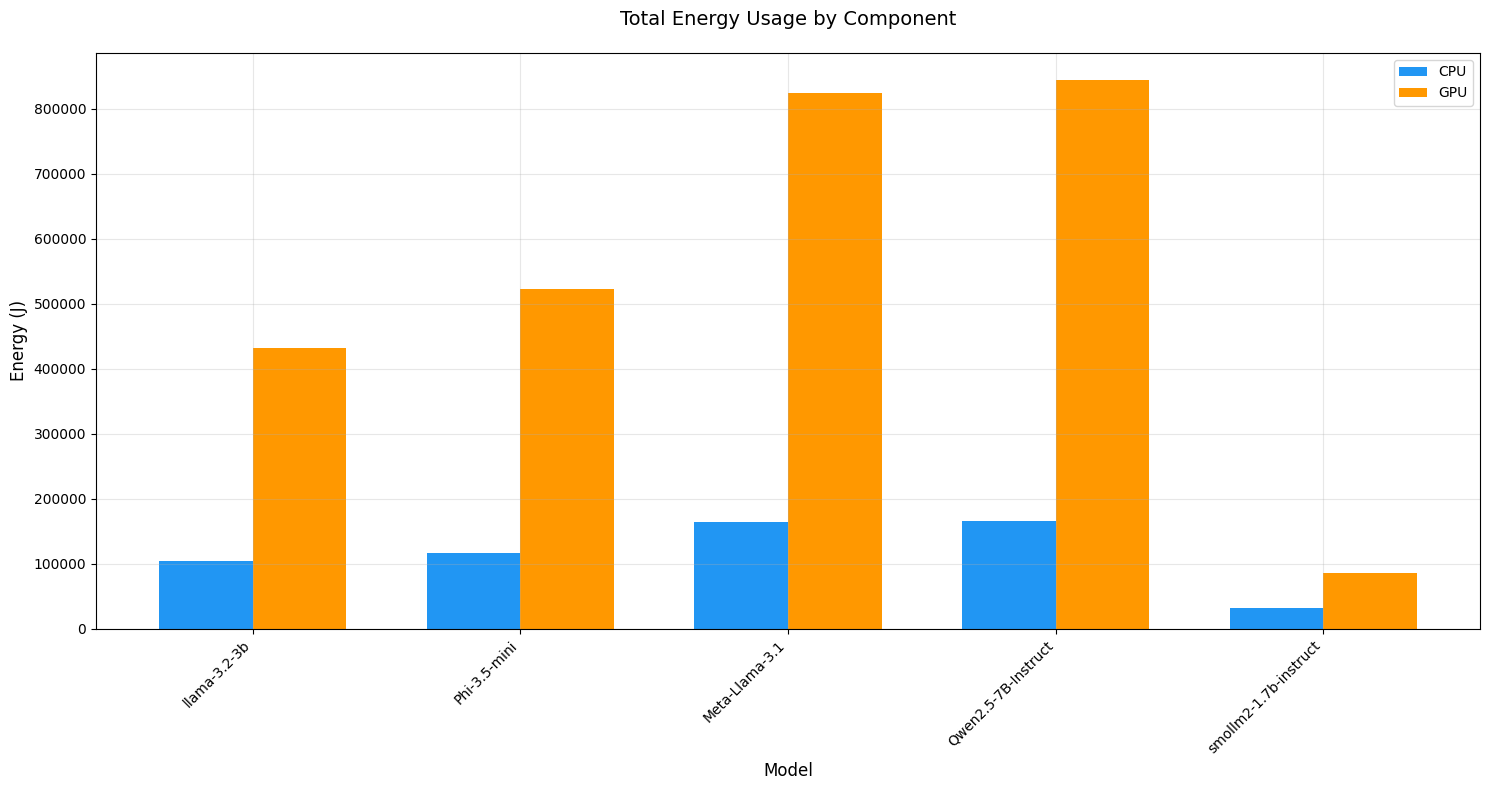

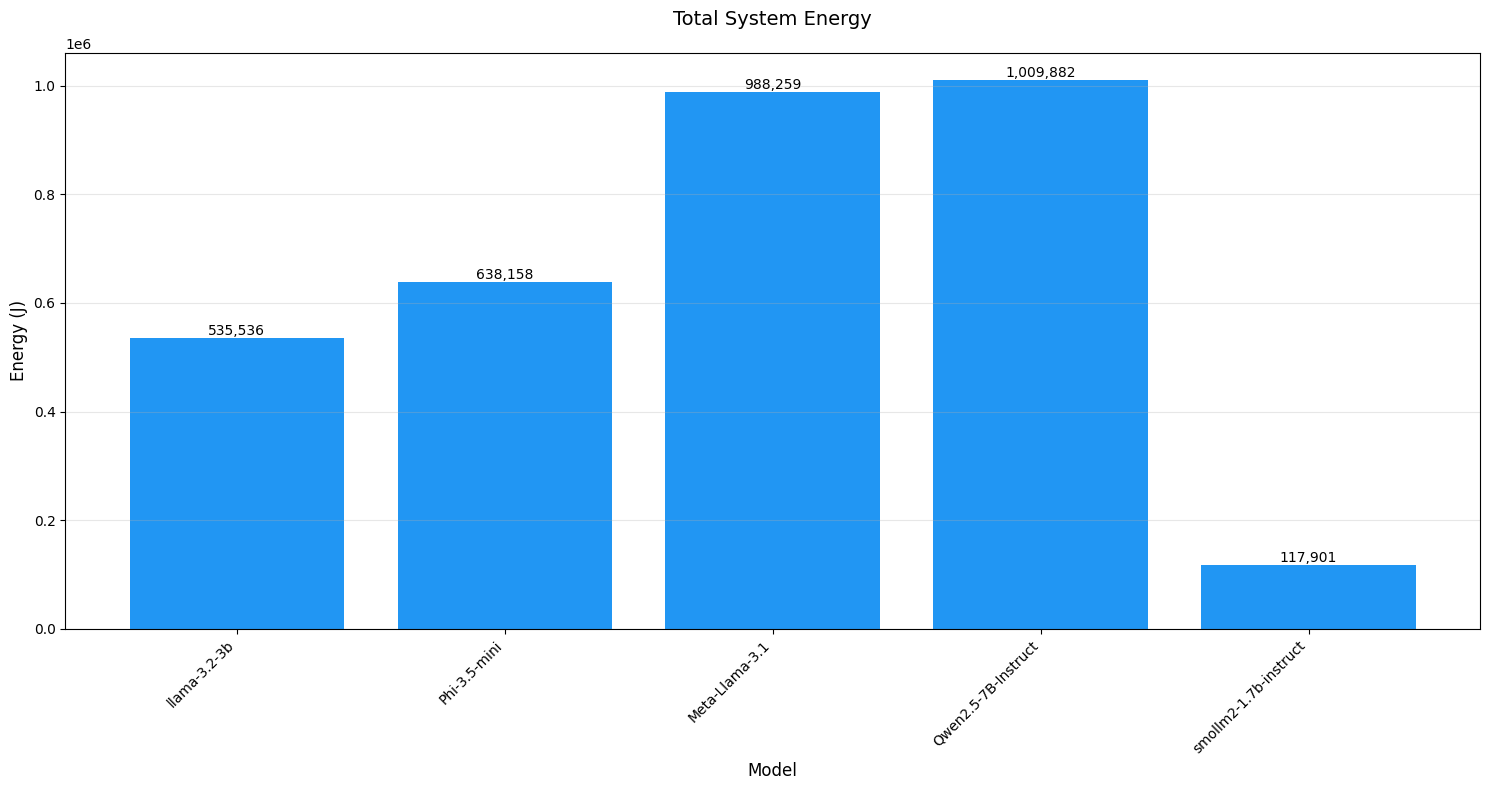

<Figure size 1500x800 with 0 Axes>

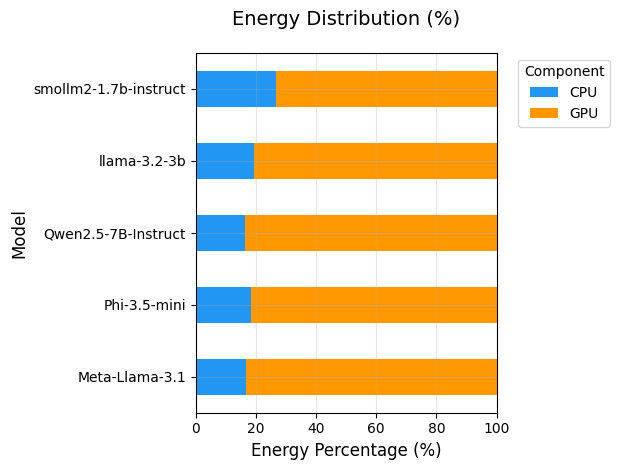

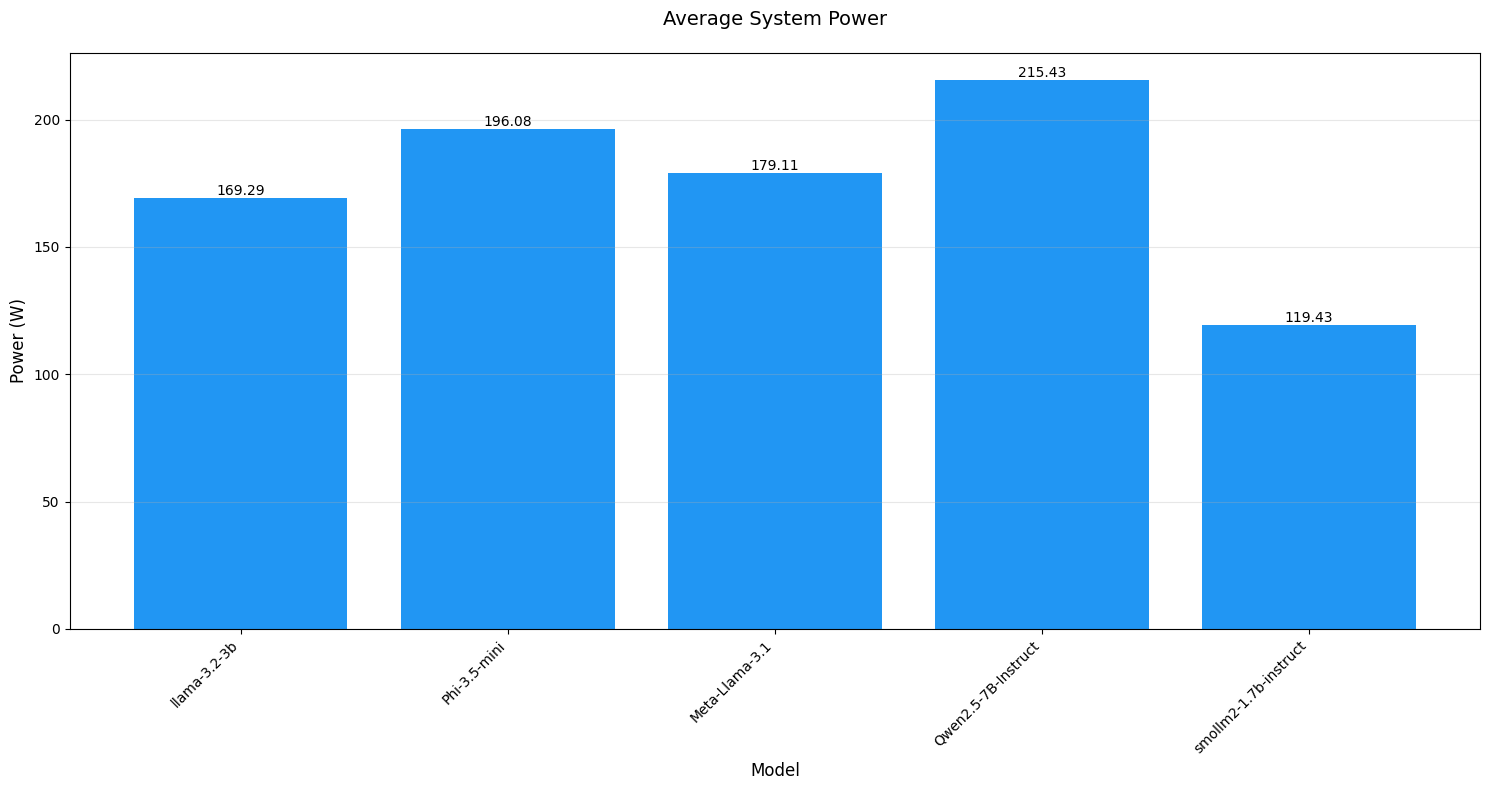

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_component_energy(model_stats_dict, figsize=(15, 8)):
    """Plot total energy usage by component (CPU/GPU) for each model"""
    plt.figure(figsize=figsize)
    
    # Prepare data
    component_data = []
    for model, df in model_stats_dict.items():
        for _, row in df[df['Component'] != 'System Total'].iterrows():
            component_data.append({
                'Model': model,
                'Component': row['Component'],
                'Energy': row['Total Energy (J)']
            })
    
    # Create DataFrame and plot
    df = pd.DataFrame(component_data)
    
    # Create grouped bar chart
    plt.figure(figsize=figsize)
    x = np.arange(len(df['Model'].unique()))
    width = 0.35
    
    # Split data by component
    cpu_data = df[df['Component'] == 'CPU']['Energy']
    gpu_data = df[df['Component'] == 'GPU']['Energy']
    
    # Plot bars
    plt.bar(x - width/2, cpu_data, width, label='CPU', color='#2196F3')
    plt.bar(x + width/2, gpu_data, width, label='GPU', color='#FF9800')
    
    # Customize plot
    plt.title('Total Energy Usage by Component', fontsize=14, pad=20)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Energy (J)', fontsize=12)
    plt.xticks(x, df['Model'].unique(), rotation=45, ha='right')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt.gcf()

def plot_total_energy(model_stats_dict, figsize=(15, 8)):
    """Plot total system energy for each model"""
    plt.figure(figsize=figsize)
    
    # Prepare data
    system_totals = []
    for model, df in model_stats_dict.items():
        total = df[df['Component'] == 'System Total']['Total Energy (J)'].iloc[0]
        system_totals.append({
            'Model': model,
            'Total Energy': total
        })
    
    df = pd.DataFrame(system_totals)
    
    # Create bar plot
    bars = plt.bar(df['Model'], df['Total Energy'], color='#2196F3')
    
    # Customize plot
    plt.title('Total System Energy', fontsize=14, pad=20)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Energy (J)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}',
                ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    return plt.gcf()

def plot_energy_distribution(model_stats_dict, figsize=(15, 8)):
    """Plot energy distribution percentage between CPU and GPU"""
    plt.figure(figsize=figsize)
    
    # Prepare data
    distribution_data = []
    for model, df in model_stats_dict.items():
        for _, row in df[df['Component'] != 'System Total'].iterrows():
            distribution_data.append({
                'Model': model,
                'Component': row['Component'],
                'Percentage': row['Energy Percentage (%)']
            })
    
    df = pd.DataFrame(distribution_data)
    
    # Create stacked horizontal bar plot
    pivot_df = df.pivot(index='Model', columns='Component', values='Percentage')
    pivot_df.plot(kind='barh', stacked=True, 
                 color=['#2196F3', '#FF9800'])
    
    # Customize plot
    plt.title('Energy Distribution (%)', fontsize=14, pad=20)
    plt.xlabel('Energy Percentage (%)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.legend(title='Component', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 100)
    
    plt.tight_layout()
    return plt.gcf()

def plot_average_power(model_stats_dict, figsize=(15, 8)):
    """Plot average system power for each model"""
    plt.figure(figsize=figsize)
    
    # Prepare data
    power_data = []
    for model, df in model_stats_dict.items():
        power = df[df['Component'] == 'System Total']['Average Power (W)'].iloc[0]
        power_data.append({
            'Model': model,
            'Average Power': power
        })
    
    df = pd.DataFrame(power_data)
    
    # Create bar plot
    bars = plt.bar(df['Model'], df['Average Power'], color='#2196F3')
    
    # Customize plot
    plt.title('Average System Power', fontsize=14, pad=20)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Power (W)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    return plt.gcf()

def plot_message_stats_comparison(model_stats_dict) -> None:
    """
    Create boxplot visualizations of message statistics.
    
    Args:
        save_path: Optional path to save the plot (e.g., 'message_stats.png')
        
    Returns:
        None - displays or saves the plot
    """
    """
    Create comprehensive boxplot visualizations comparing message-level statistics across models.
    
    Args:
        model_stats_dict: Dictionary mapping model names to their message statistics DataFrames
        save_path: Optional path to save the plot
        
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(3, 2, height_ratios=[2, 2, 1.5])
    
    # Prepare combined data for plotting
    combined_data = []
    for model_name, stats_df in model_stats_dict.items():
        df_copy = stats_df.copy()
        df_copy['Model'] = model_name
        combined_data.append(df_copy)
    
    combined_df = pd.concat(combined_data, ignore_index=True)
    
    # 1. Processing Time Distribution
    ax1 = fig.add_subplot(gs[0, 0])
    sns.boxplot(data=combined_df, x='Model', y='processing_time_ms', ax=ax1)
    ax1.set_title('Processing Time Distribution by Model', fontsize=12, pad=20)
    ax1.set_xlabel('Model', fontsize=10)
    ax1.set_ylabel('Time (ms)', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Power Usage Distribution
    ax2 = fig.add_subplot(gs[0, 1])
    power_data = pd.melt(combined_df, 
                        id_vars=['Model'],
                        value_vars=['cpu_power_watts', 'gpu_power_watts', 'total_power_watts'],
                        var_name='Component',
                        value_name='Power (W)')
    sns.boxplot(data=power_data, x='Model', y='Power (W)', hue='Component', ax=ax2)
    ax2.set_title('Power Usage Distribution by Component', fontsize=12, pad=20)
    ax2.set_xlabel('Model', fontsize=10)
    ax2.tick_params(axis='x', rotation=45)
    ax2.legend(title='Component', bbox_to_anchor=(1.05, 1))
    
    # 3. Energy Usage Distribution
    ax3 = fig.add_subplot(gs[1, 0])
    energy_data = pd.melt(combined_df,
                         id_vars=['Model'],
                         value_vars=['cpu_energy_joules', 'gpu_energy_joules', 'total_energy_joules'],
                         var_name='Component',
                         value_name='Energy (J)')
    sns.boxplot(data=energy_data, x='Model', y='Energy (J)', hue='Component', ax=ax3)
    ax3.set_title('Energy Usage Distribution by Component', fontsize=12, pad=20)
    ax3.set_xlabel('Model', fontsize=10)
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(title='Component', bbox_to_anchor=(1.05, 1))
    
    # 4. Processing Speed (Tokens/s)
    ax4 = fig.add_subplot(gs[1, 1])
    if 'tokens_per_second' in combined_df.columns and not combined_df['tokens_per_second'].isna().all():
        sns.boxplot(data=combined_df, x='Model', y='tokens_per_second', ax=ax4)
        ax4.set_title('Processing Speed Distribution', fontsize=12, pad=20)
        ax4.set_xlabel('Model', fontsize=10)
        ax4.set_ylabel('Tokens per Second', fontsize=10)
        ax4.tick_params(axis='x', rotation=45)
    else:
        ax4.text(0.5, 0.5, 'Tokens per Second\ndata not available',
                ha='center', va='center')
        ax4.set_title('Processing Speed', fontsize=12, pad=20)
    
    # 5. Summary Statistics Table
    ax5 = fig.add_subplot(gs[2, :])
    summary_data = []
    for model in combined_df['Model'].unique():
        model_data = combined_df[combined_df['Model'] == model]
        summary_data.append({
            'Model': model,
            'Avg Processing Time (ms)': f"{model_data['processing_time_ms'].mean():.1f}",
            'Avg Power (W)': f"{model_data['total_power_watts'].mean():.2f}",
            'Total Energy (J)': f"{model_data['total_energy_joules'].sum():.1f}",
            'Message Count': len(model_data),
            'Avg Tokens/s': f"{model_data['tokens_per_second'].mean():.1f}" if 'tokens_per_second' in model_data.columns else 'N/A'
        })
    
    summary_df = pd.DataFrame(summary_data)
    ax5.axis('tight')
    ax5.axis('off')
    table = ax5.table(cellText=summary_df.values,
                     colLabels=summary_df.columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*len(summary_df.columns))
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()

    return fig

# Example usage:
# Assuming model_stats is your dictionary of model statistics
fig1 = plot_component_energy(model_stats)
fig2 = plot_total_energy(model_stats)
fig3 = plot_energy_distribution(model_stats)
fig4 = plot_average_power(model_stats)

# To save the figures:
fig1.savefig('component_energy.png', dpi=600, bbox_inches='tight')
fig2.savefig('total_energy.png', dpi=600, bbox_inches='tight')
fig3.savefig('energy_distribution.png', dpi=600, bbox_inches='tight')
fig4.savefig('average_power.png', dpi=600, bbox_inches='tight')